# Using the Scheduler

The scheduler will translate a `QuantumCircuit` into a Pulse `Schedule`, using gate and measurement _calibrations_: an optimized pulse-level description of an operation on particular qubits.

Backends that are OpenPulse enabled will typically have calibrations defined for measurements and for each of its basis gates. Calibrations can also be defined or updated by the user.

## Basic usage

To start, build a quantum circuit as you would normally. For our example below, we create a simple Bell state.

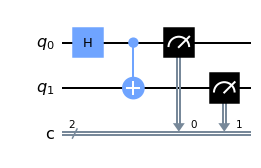

In [1]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure([0, 1], [0, 1])

circ.draw('mpl')

We'll use the mocked backend, `FakeAlmaden`, to demonstrate how to use the scheduler. It contains default calibrations for measurement and for its basis gates. The Hadamard operation is not one of those basis gates, so we use the transpiler to compile our input circuit to an equivalent circuit in terms of the basis gates of the device.

In [2]:
from qiskit import transpile, schedule as build_schedule
from qiskit.test.mock import FakeAlmaden

backend = FakeAlmaden()

transpiled_circ = transpile(circ, backend)  # Undefined Hadamard is replaced by U1
schedule = build_schedule(transpiled_circ, backend)

Let's see how our schedule `schedule` built from the circuit `transpiled_circ` looks.

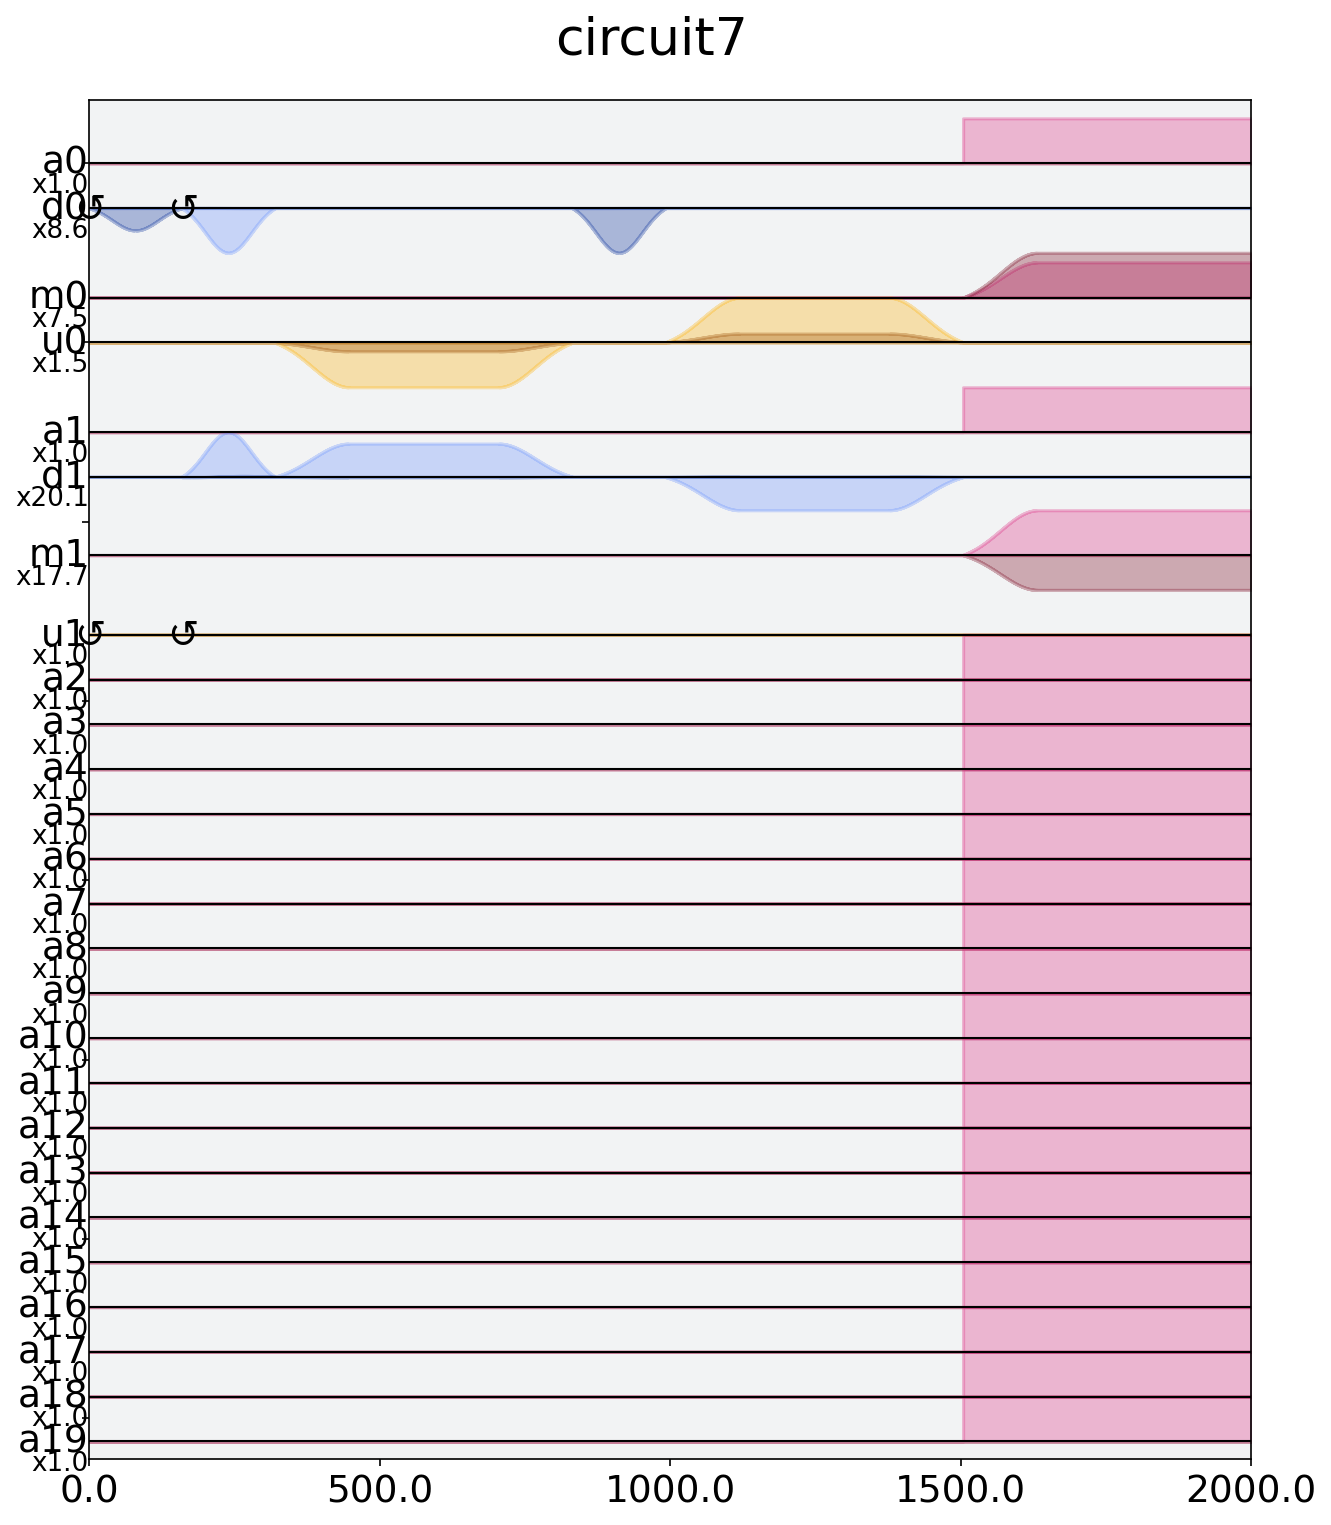

In [3]:
schedule.draw(plot_range=[0, 2000])

That covers the basics! We used the transpiler to rewrite the circuit in terms of the basis gates, and then used the backend's default calibrations to schedule the transpiled circuit. Next we will go through scheduling with calibrations we will build ourselves.

## Scheduling with custom gate definitions

If your input circuit has calibrations defined, it will use those calibrations when scheduling your circuit.

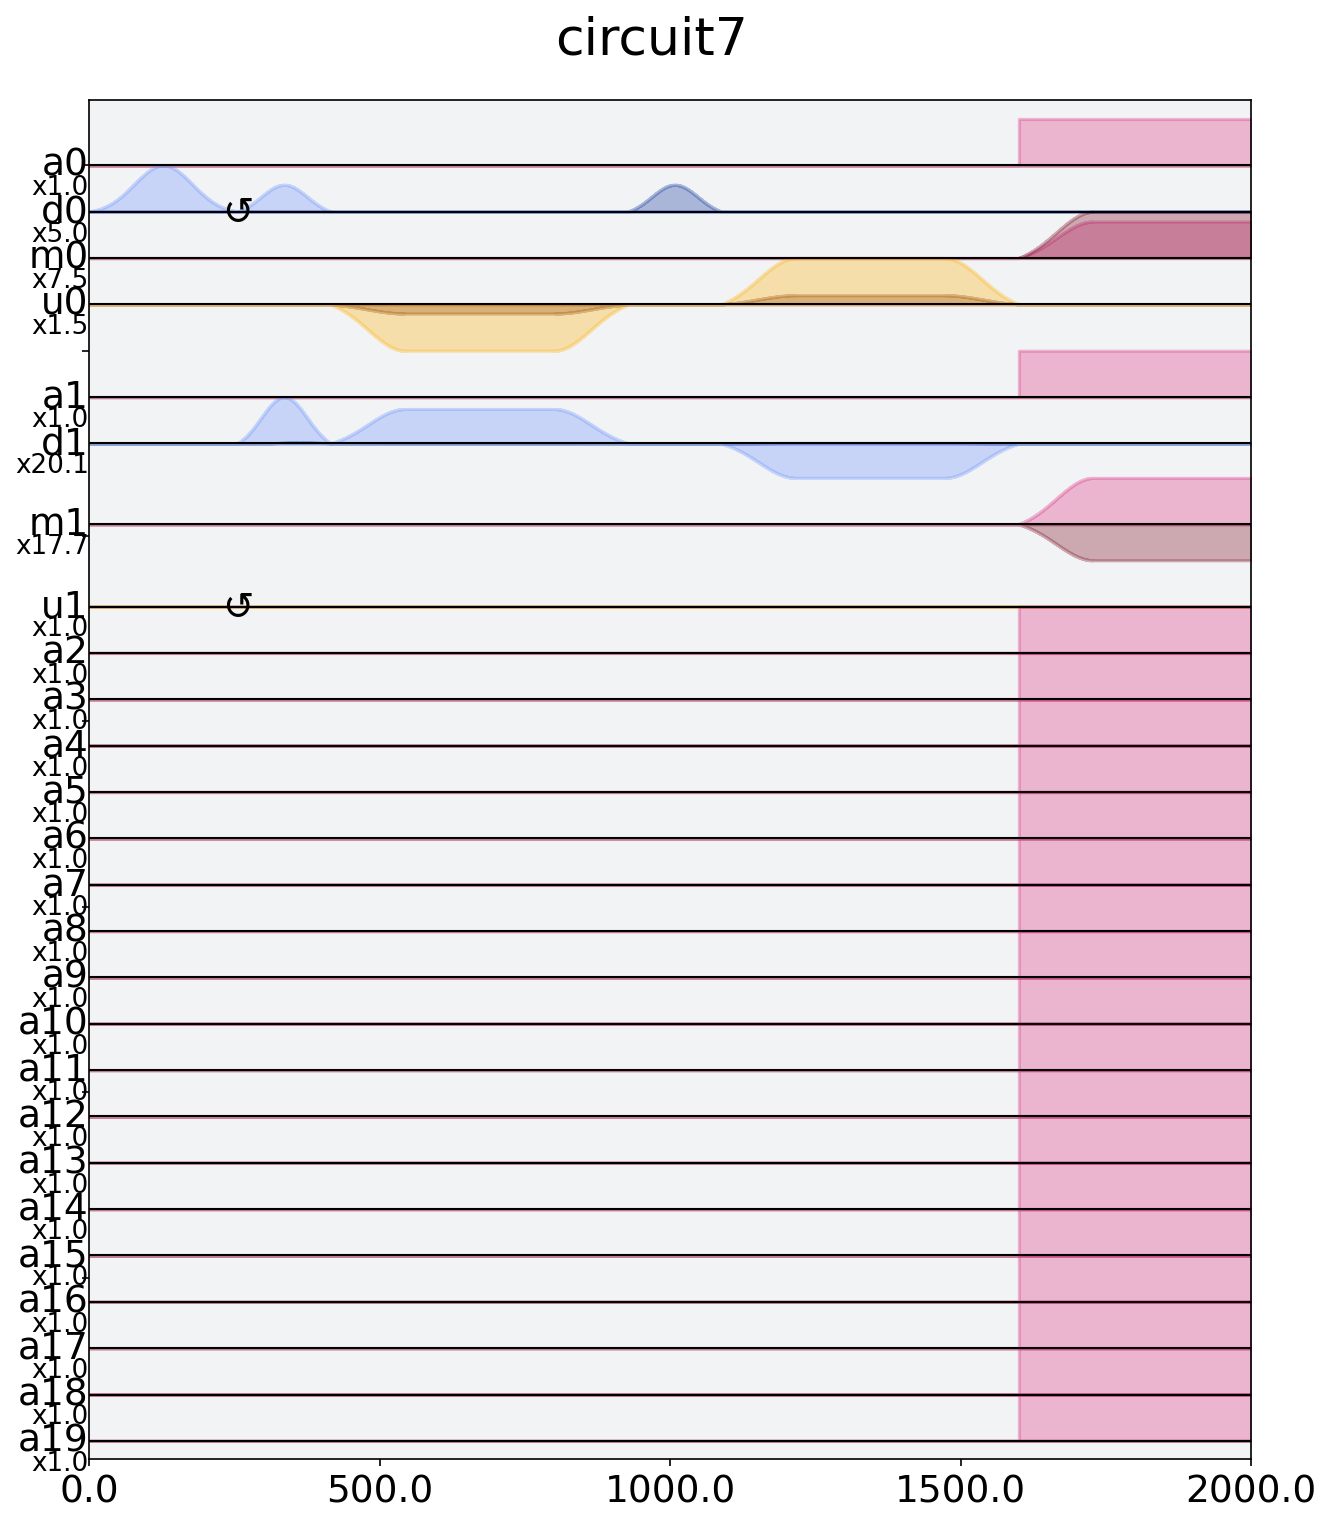

In [4]:
from qiskit import pulse

with pulse.build() as h_q0:
    pulse.play(pulse.library.Gaussian(duration=256, amp=0.2, sigma=50, name='custom'),
               pulse.DriveChannel(0))

circ.add_calibration('h', [0], h_q0)

schedule = build_schedule(circ, backend)
schedule.draw(plot_range=[0, 2000])

Notice that the initial pulse on `D0`, the Hadamard gate, is now implemented with our custom pulse.

## Scheduler methods

The scheduler can follow multiple routines. By default, it follows an _as late as possible_ (ALAP) rule. Another scheduling method is _as soon as possible_, (ASAP). For both methods, the output schedule is minimal: in the longest-duration operation path of the input circuit, the start time of each operation is the end time of the proceeding operation. The methods determine how to schedule operations outside that longest path.

This is made clear through an example:

In [5]:
circ = QuantumCircuit(2, 2)
circ.x(0)
circ.x(0)
circ.x(1)
circ.measure([0, 1], [0, 1])

For our mocked backend, these $X$ gate operations are each the same duration (`duration = 160 dt`). For the schedule to be minimal, the two $X$ operations on qubit 0 will be scheduled back-to-back, and the measurement pulse will immediately follow the second of those pulses.

ALAP will choose the latest valid time to schedule lesser-constrained operations, so the $X$ gate on qubit 1 will play in sync with the second $X$ gate on qubit 0.

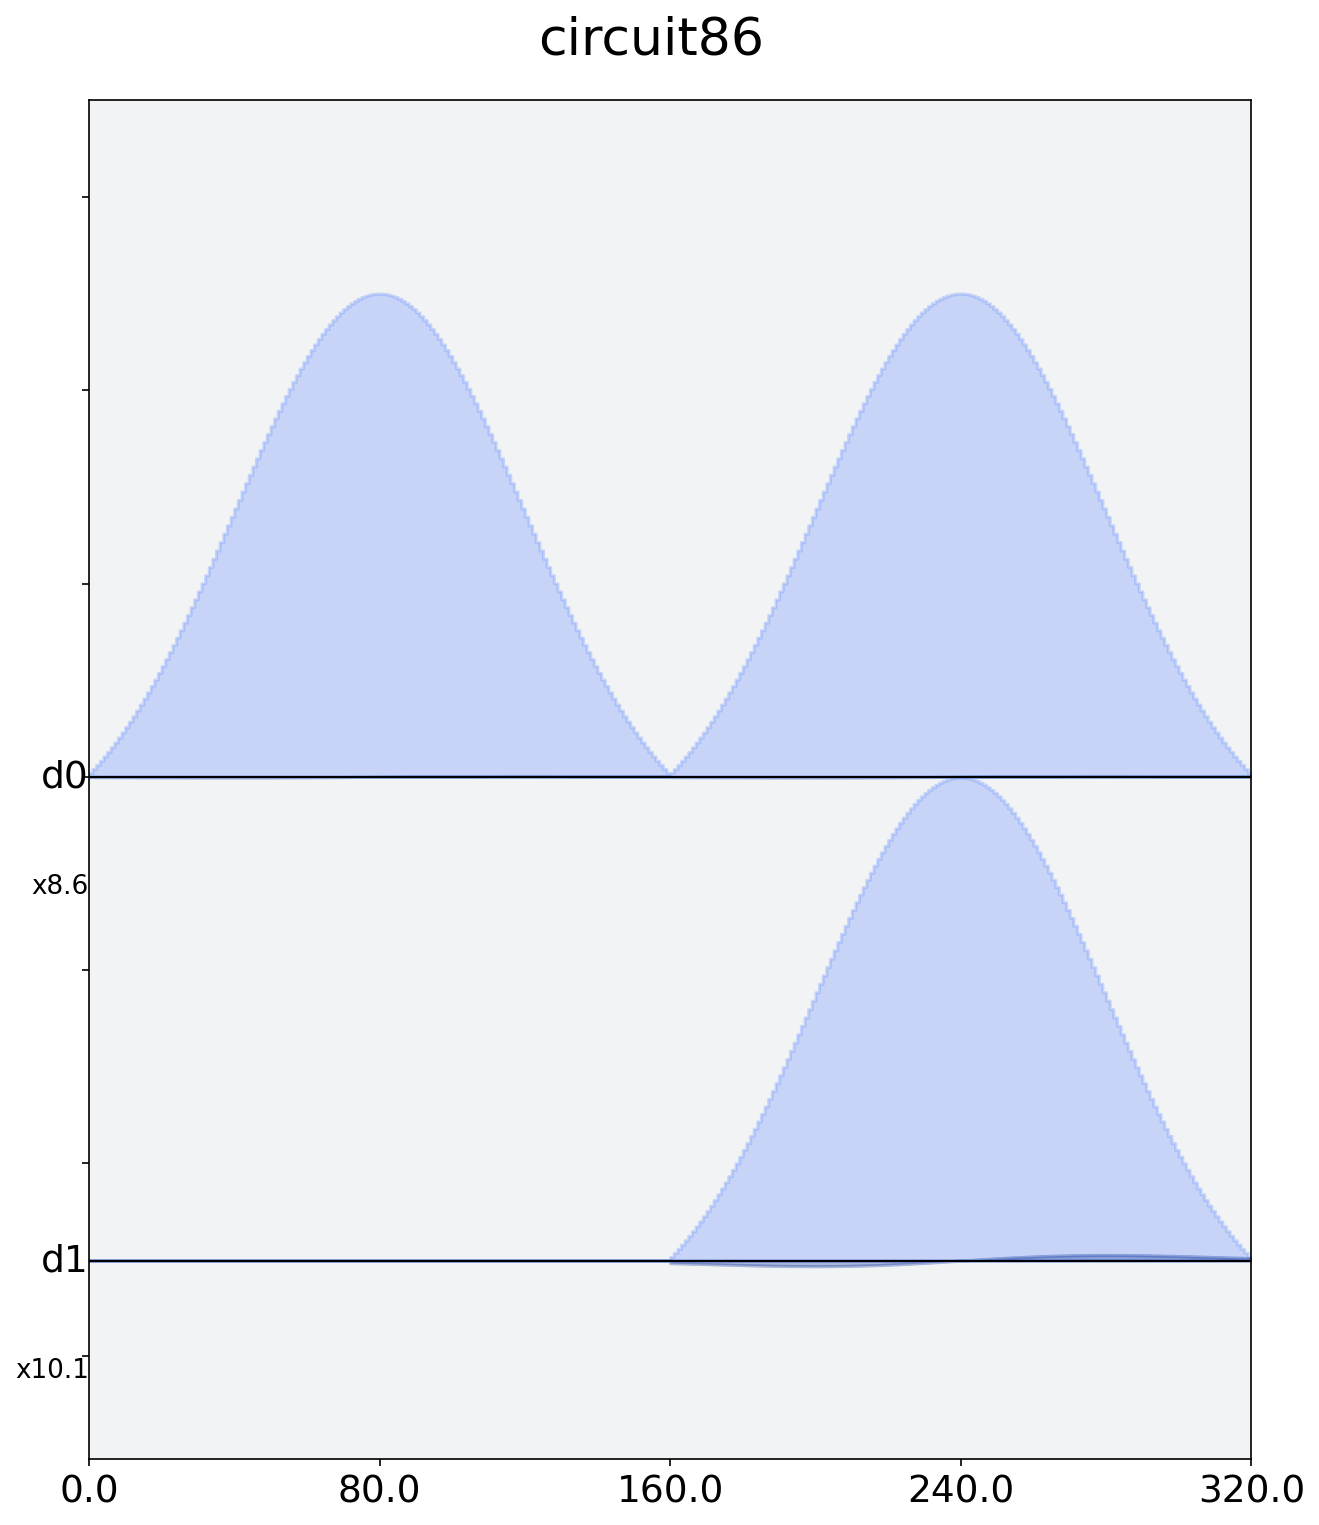

In [6]:
schedule = build_schedule(circ, backend,
                          method="as_late_as_possible")
schedule.draw(channels=[pulse.DriveChannel(0), pulse.DriveChannel(1)])

On the other hand, as the name suggests, ASAP will schedule operations as soon as its resources are free. Thus, the $X$ gate on qubit 1 will be scheduled at `time=0`, in sync with the first $X$ gate on qubit 0.

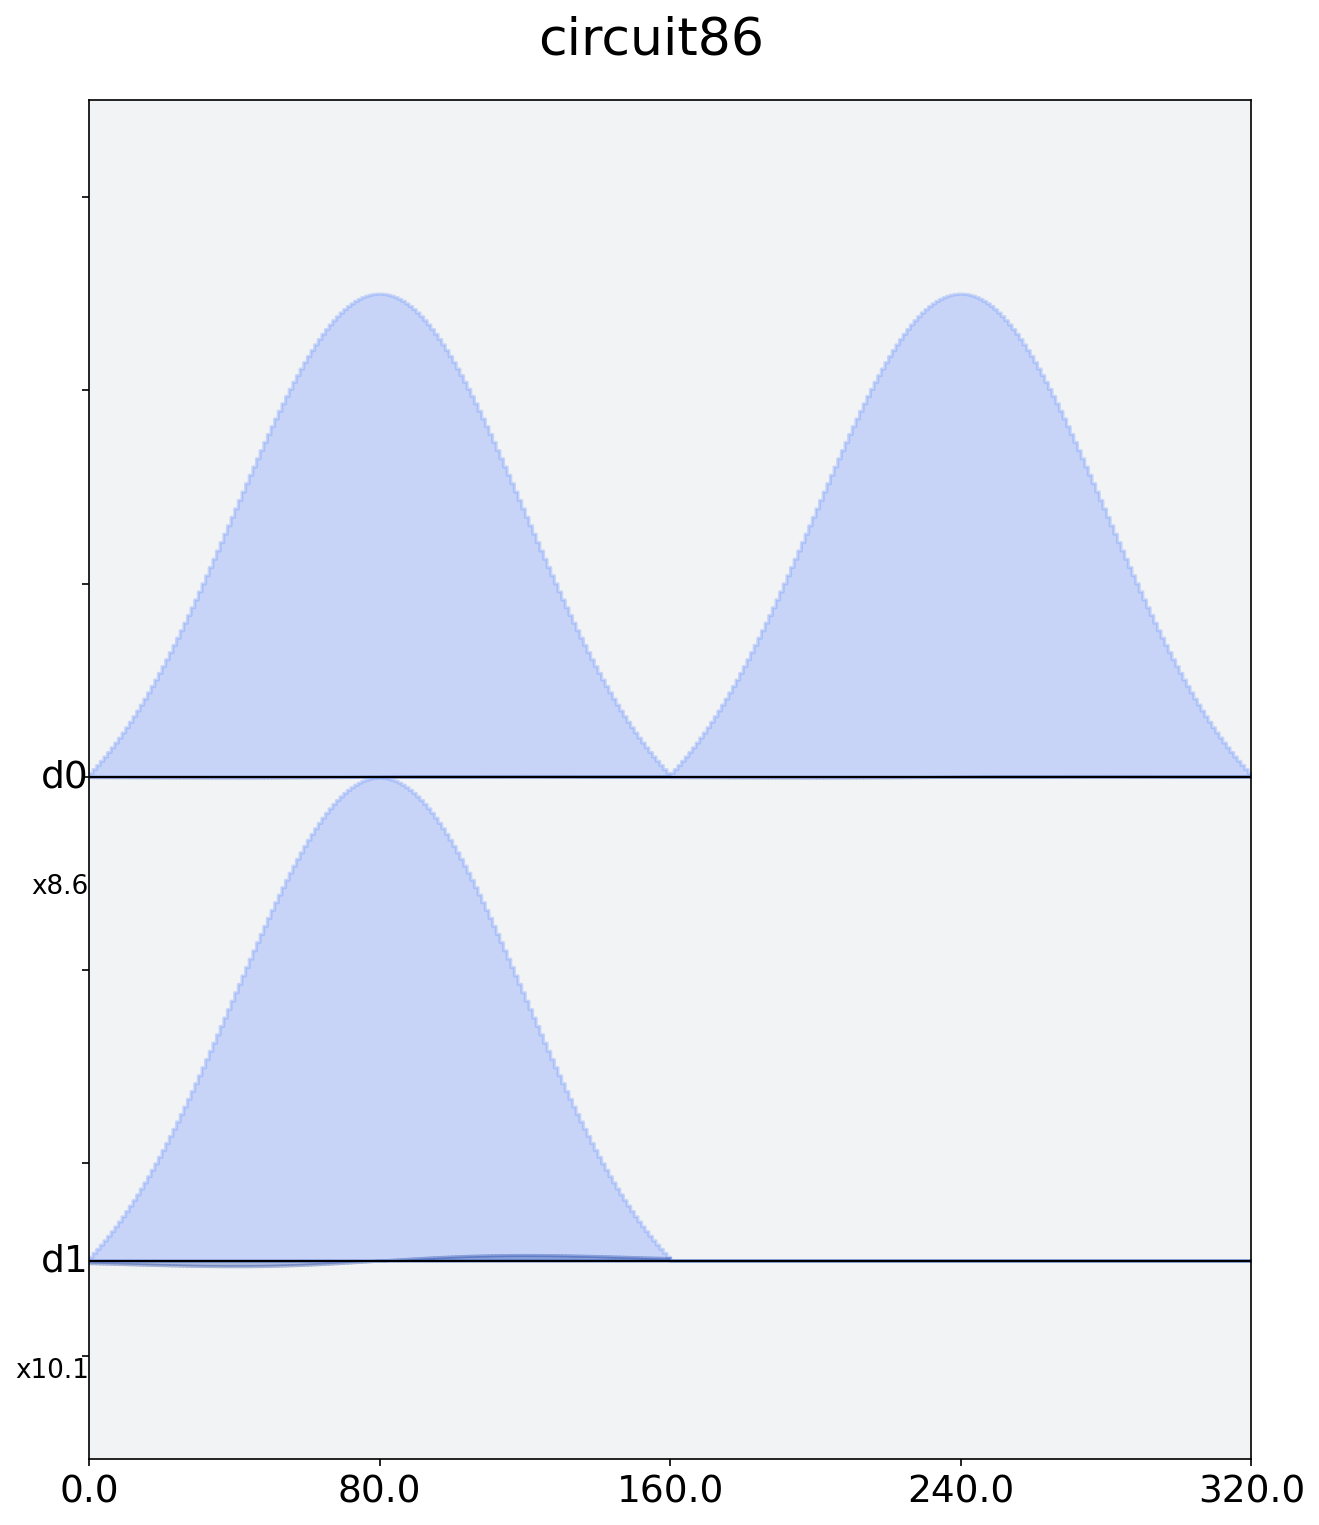

In [7]:
schedule = build_schedule(circ, backend,
                          method="as_soon_as_possible")
schedule.draw(channels=[pulse.DriveChannel(0), pulse.DriveChannel(1)])

ALAP is the default because it allows qubits to remain idle as long as possible. In this case, the difference between ALAP and ASAP may be negligible, but in ALAP, qubit 0 has _no_ time to decay from the excited state before measurement.

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright